In [1]:
import pylabnet.hardware.awg.zi_hdawg as zi_hdawg
from pylabnet.utils.logging.logger import LogClient

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import time

from IPython.display import clear_output, display

import pyvisa
from pylabnet.utils.logging.logger import LogClient
from pylabnet.network.client_server.agilent_e4405B import Client
import pylabnet.hardware.spectrum_analyzer.agilent_e4405B as sa_hardware


import itertools as it
import pandas as pd
import seaborn as sns

from pylabnet.utils.logging.logger import LogService
from pylabnet.network.core.generic_server import GenericServer
import os
import sys

# Instantiante HDAWG

In [2]:
dev_id = 'dev8227'

# Instantiate
logger = LogClient(
    host='localhost',
    port=12351,
    module_tag=f'ZI HDAWG {dev_id}'
)

In [3]:
# Instanciate Hardware class
hd = zi_hdawg.Driver(dev_id, logger)

# Select channel grouping
hd.set_channel_grouping(0)

C:\Users\pylabnet\pylabnet\env\lib\site-packages\zhinst-20.1.1818-py3.7-win-amd64.egg\zhinst\utils.py:168: UserWarning: There is a mismatch between the versions of the API and Data Server. The API reports version `20.01' (revision: 200101818) whilst the Data Server has version `20.07' (revision 200702238). See the ``Compatibility'' Section in the LabOne Programming Manual for more information.
  warnings.warn(message)


# Connect to Spectrum Analyzer

In [4]:
sa = Client(
    host='localhost',
    port=12356
)

# Reset spectrum analzyer
sa.write('*RST')

(6, <StatusCode.success: 0>)

# Setup I/Q Outputs

For reference, we're using the following I/Q mixer https://www.markimicrowave.com/Assets/datasheets/MMIQ-0218H.pdf?v=061820. The local oscillator is set to 12 GHz at a power of 24 dBm. 

In [5]:
carrier = 12*1e9 # 12 GHz
signal_freq = 300*1e6 # 300 MHz
phase = 0
amplitude_i = 650*1e-3
amplitude_q = 650*1e-3

In [6]:
# Assign oscillator 1 to sine output 2
hd.seti('sines/1/oscselect', 0)

# Set carrier frequency
hd.setd('oscs/0/freq', signal_freq)

# Set I and Q amplitude
hd.setd('sines/0/amplitudes/0', amplitude_i)
hd.setd('sines/1/amplitudes/1', amplitude_q)

# Set phase offset between I and Q
hd.setd('sines/0/phaseshift', phase)

# Enable sine waves
hd.seti('sines/0/enables/0', 1)
hd.seti('sines/1/enables/1', 1)

In [7]:
# Enable wave output on and 2
def enable():
    hd.enable_output(0)
    hd.enable_output(1)
    
# disable wave output on and 2
def disable():
    hd.disable_output(0)
    hd.disable_output(1)

In [8]:
enable()

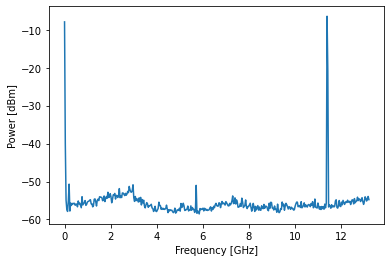

In [9]:
sa.plot_trace()

In [10]:
# Center frequency at carrier frequency
sa.set_center_frequency(carrier)
sa.set_frequency_span(6*signal_freq)

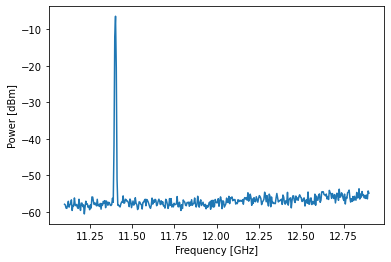

In [11]:
sa.plot_trace()

# Set markers

In [12]:
# Marker for upper sideband.
upp_sb_marker = sa_hardware.E4405BMarker(sa,'Upper Sideband',1)
lower_sb_marker = sa_hardware.E4405BMarker(sa,'Lower Sideband',2)
carrier_marker = sa_hardware.E4405BMarker(sa,'Carrier',3)

In [13]:
upp_sb_marker.look_right()

In [14]:
lower_sb_marker.look_left()

In [15]:
# define target frequencies
markers = [upp_sb_marker, lower_sb_marker, carrier_marker]
target_freqs = np.array([12.3, 11.7, 12])*1e9
max_deviation = 1e6 # How much 

In [16]:
for marker, target_freq in zip(markers, target_freqs):
    marker_freq = marker.read_freq()
    
    assert abs(marker_freq - target_freq) < max_deviation, f"{marker.name} has wrong frequecy: {marker_freq / 1e9} GHz"
    print(f"Marker '{marker.name}' parked at {marker_freq / 1e9:.4f} GHz reads {marker.get_power():.2f} dbm.")

AssertionError: Upper Sideband has wrong frequecy: 11.400601 GHz

## Calibrate Phase

Let's now follow the same appraoch to suppress the lower sideband by performing a 2D sweep over the phase / amplitude imbalance space. We will impose that the sum of I and Q amplitudes is fixed: $A_I + A_Q = 2A_0$, and we sweep the ratio $q$ between the two amplitudes: $\frac{A_I}{A_Q} = q$. We thus get: $A_Q = 2  A_0 \frac{1}{1+q}$ and  $A_I = 2  A_0 \frac{q}{1+q}$ 

In [ ]:
def sweep_phase_amp_imbalance():
    
    carrier_power = np.zeros((num_points, num_points))

    for i, j in it.product(range(num_points), repeat=2):
            
        phase = phases[i]
        q = qs[j]
        
        # Calculate amplitudes
        amp_i = 2 * q / (1 + q) * a0
        amp_q = 2 * a0 / (1 + q)
        
        # Set I and Q amplitudes
        hd.setd('sines/0/amplitudes/0', amp_i)
        hd.setd('sines/1/amplitudes/1', amp_q)
        
        # Set phaseshift
        hd.setd('sines/0/phaseshift', phase)

        # Read lower sideband power
        lower_sideband_power[i,j] = lower_sb_marker.get_power()
        
        print(f'{i/num_points * 100} % done')
        clear_output(wait=True)

In [ ]:
# Sweep phase offset
phase_min = 55
phase_max = 70

# Sweep amplitude imbalance 
q_min = 0.7
q_max = 1
a0 = 650*1e-3

num_points = 20

# Instantiate arrays
phases = np.linspace(phase_min, phase_max, num_points)
qs = np.linspace(q_min, q_max, num_points)
lower_sideband_power = np.zeros((num_points, num_points))

sweep_phase_amp_imbalance()

In [ ]:
# Create heatmap from sweep data

# Store results in dataframe for easy plotting
lower_sideband_data = pd.DataFrame(lower_sideband_power,
                   index=np.round(phases, 1),
                   columns=np.round(qs, 2))

fig1, ax1 = plt.subplots(figsize=(8, 5))    
ax1 = sns.heatmap(lower_sideband_data, xticklabels=5,  yticklabels=5,  cbar_kws={'label': 'lower sideband power [dBm]'})
ax1.set(ylabel='Phase shift', xlabel='Amplitude imbalance')

In [ ]:
def set_optimal_point(opt_phase, opt_q):

    amp_i_opt = 2 * opt_q / (1 + opt_q) * a0 
    amp_q_opt = 2 * a0 / (1 + opt_q) 

    # Set optimal I and Q amplitudes
    hd.setd('sines/0/amplitudes/0', amp_i_opt)
    hd.setd('sines/1/amplitudes/1', amp_q_opt)

    # Set optimal phaseshift
    hd.setd('sines/0/phaseshift', opt_phase)

In [ ]:
# Read off optimal values
opt_phase = phases[np.where(lower_sideband_power == np.amin(lower_sideband_power))[0][0]]
opt_q = qs[np.where(lower_sideband_power == np.amin(lower_sideband_power))[1][0]]

set_optimal_point(opt_phase, opt_q)
sa.plot_trace()
print(opt_phase, opt_q)

In [ ]:
# Finer sweep over portion of phase-amplitude-imbalance space to obtain more accurate minimum

cushion_param = 2
q_cushion = cushion_param*(q_max-q_min)/num_points
phase_cushion = cushion_param*(phase_max-phase_min)/num_points

# Reset sweep window to zoom in on minimum
q_max = opt_q + q_cushion
q_min = opt_q - q_cushion
phase_max = opt_phase + phase_cushion
phase_min = opt_phase - phase_cushion

num_points = 30

# Instantiate arrays
phases = np.linspace(phase_min, phase_max, num_points)
qs = np.linspace(q_min, q_max, num_points)
lower_sideband_power = np.zeros((num_points, num_points))

sweep_phase_amp_imbalance()

In [ ]:
# Create heatmap for finer sweep

# Store results in dataframe for easy plotting
lower_sideband_data = pd.DataFrame(lower_sideband_power,
                   index=np.round(phases, 1),
                   columns=np.round(qs, 2))


fig1, ax1 = plt.subplots(figsize=(8, 5))    
ax1 = sns.heatmap(lower_sideband_data, xticklabels=5,  yticklabels=5,  cbar_kws={'label': 'lower sideband power [dBm]'})
ax1.set(ylabel='Phase shift', xlabel='Amplitude imbalance')

In [ ]:
# Reset optimum values
opt_phase = phases[np.where(lower_sideband_power == np.amin(lower_sideband_power))[0][0]]
opt_q = qs[np.where(lower_sideband_power == np.amin(lower_sideband_power))[1][0]]

set_optimal_point(opt_phase, opt_q)
sa.plot_trace()
print(opt_phase, opt_q)

## DC Offset Calibration

In [ ]:
def sweep_dc_offsets(dc_min_i, dc_max_i, dc_min_q, dc_max_q, num_points):
    
    # Sweep 2D parameter space of DC offsets and record carrier power
    voltages_i = np.linspace(dc_min_i, dc_max_i, num_points)
    voltages_q = np.linspace(dc_min_q, dc_max_q, num_points)

    carrier_power = np.zeros((num_points, num_points))

    for i, j in it.product(range(num_points), repeat=2):

        # Set I DC-offset
        hd.setd('sigouts/0/offset', voltages_i[i])

        # Set Q DC-offset
        hd.setd('sigouts/1/offset', voltages_q[j])

        # Read carrier power
        carrier_power[i,j] = carrier_marker.get_power()
        print(f'{i/num_points * 100} % done')
        clear_output(wait=True)
        
    return carrier_power, voltages_i, voltages_q

In [ ]:
# Define sweep window for carrier minimization

dc_min_i = -5e-3
dc_max_i = 15e-3
dc_min_q = -5e-3
dc_max_q = 15e-3

num_points = 30

carrier_power, voltages_i, voltages_q = sweep_dc_offsets(dc_min_i, dc_max_i, dc_min_q, dc_max_q, num_points)

In [ ]:
# Create heatmap from data

# Store results in dataframe for easy plotting
dc_sweep_data = pd.DataFrame(carrier_power,
                   columns=np.round(voltages_q/1e-3, 1),
                   index=np.round(voltages_i/1e-3, 1))

fig, ax = plt.subplots(figsize=(8, 5))    
ax = sns.heatmap(dc_sweep_data, xticklabels=5,  yticklabels=5,  cbar_kws={'label': 'carrier power [dBm]'})
ax.set(xlabel='DC offset Q signal [mV]', ylabel='DC offset I signal [mV]')

In [ ]:
# Retrieve optimal DC offsets
dc_offset_i_opt = voltages_i[np.where(carrier_power == np.amin(carrier_power))[0][0]]
dc_offset_q_opt = voltages_q[np.where(carrier_power == np.amin(carrier_power))[1][0]]

# Set optimal offset
hd.setd('sigouts/0/offset', dc_offset_i_opt)
hd.setd('sigouts/1/offset', dc_offset_q_opt)

sa.plot_trace()
print(dc_offset_i_opt, dc_offset_q_opt)